In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
import real_ips

In [3]:
%pwd

'/Users/andreas/PycharmProjects/aims_lab'

In [4]:
%ls

Section4.ipynb              real_data/
Visualization.ipynb         real_ips.py
__pycache__/                set1/
fingerprinting_skeleton.py  set2/
handout.pdf                 submit.py


In [43]:
import numpy as np

In [563]:
test_locations, test_rsss = real_ips.load_real_data_test('real_data')

In [564]:
train_locations, train_rsss = real_ips.load_real_data_train('real_data')

In [566]:
test_locations, train_locations

(array([[7.22222222, 4.        ],
        [6.44444444, 2.        ],
        [6.44444444, 2.        ]]), array([[1.4 , 1.15],
        [1.2 , 3.1 ],
        [1.35, 5.5 ],
        [1.35, 6.9 ],
        [1.35, 8.8 ],
        [4.1 , 0.8 ],
        [4.7 , 2.8 ],
        [4.8 , 4.  ],
        [4.8 , 5.7 ],
        [4.8 , 8.3 ],
        [7.2 , 1.5 ],
        [7.7 , 3.4 ],
        [7.96, 5.69],
        [7.95, 6.67],
        [7.95, 8.2 ]]))

In [373]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [374]:
from sklearn import preprocessing

In [567]:
mac_encoder = preprocessing.LabelEncoder()

In [568]:
all_macs = set.union(*[set(list(train_rss[:,0])) for train_rss in train_rsss])

In [569]:
mac_encoder.fit(list(all_macs))

LabelEncoder()

In [570]:
def convert_mac_to_labels(rsss, mac_encoder):
    for i in range(len(rsss)):
        rsss[i][:,0] = mac_encoder.transform(rsss[i][:, 0])
        rsss[i] = rsss[i].astype(int)
    return rsss

train_rsss=convert_mac_to_labels(train_rsss, mac_encoder)
test_rsss=convert_mac_to_labels(test_rsss, mac_encoder)


In [571]:
min([np.min(rss) for rss in train_rsss]), min([np.min(rss) for rss in test_rsss])

(-93, -92)

In [572]:
lowest_rss = -94 # is a really shoddy signal, acc to https://www.accuware.com/support/knowledge-base/what-is-the-signal-strength-rss/

In [573]:
#for i, train_rss in enumerate(train_rsss):
sorted([len(train_rss) for train_rss in train_rsss])

[771,
 859,
 907,
 920,
 927,
 981,
 1004,
 1005,
 1071,
 1087,
 1093,
 1121,
 1128,
 1245,
 1520]

In [574]:
all_labels = list(range(len(mac_encoder.classes_)))

def data_by_mac(rsss):
    locations_by_mac = [[] for i in all_labels]
    rss_by_mac =  [[] for i in all_labels]
    
    all_labels_set = set(all_labels)

    for i, train_rss in enumerate(train_rsss):
        location = train_locations[i]
        found_macs = set()
        for sample in train_rss:
            locations_by_mac[sample[0]].append(location)
            rss_by_mac[sample[0]].append(sample[1])
            found_macs.add(sample[0])

        for missing_mac in all_labels_set - found_macs:
            locations_by_mac[missing_mac].append(location)
            rss_by_mac[missing_mac].append(lowest_rss)
    return [np.array(location_by_mac) for location_by_mac in locations_by_mac], np.array(rss_by_mac)

locations_by_mac, rss_by_mac = data_by_mac(train_rsss)

In [575]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [576]:
gps = [GaussianProcessRegressor(kernel=RBF(3.0)+WhiteKernel(1.0), n_restarts_optimizer=5, normalize_y=True) for i in range(len(all_labels))]

In [577]:
for i, (locations, rsss) in enumerate(zip(locations_by_mac, rss_by_mac)):
    gps[i].fit(np.array(locations).astype(float), np.array(rsss).astype(float))

In [578]:
gps[0].predict([(1,1)], return_std=True)

(array([-86.52830189]), array([3.17297395]))

In [579]:
min_grid = np.floor(np.min(train_locations[:], axis=0))
max_grid = np.ceil(np.max(train_locations[:], axis=0))

In [580]:
min_grid, max_grid

(array([1., 0.]), array([8., 9.]))

In [613]:
min_grid=(0,0)
max_grid=(10,10)

In [625]:
tics = 30
grid_locations = np.array([(x, y) 
                  for x in np.linspace(min_grid[0], max_grid[0], tics) 
                           for y in np.linspace(min_grid[1], max_grid[1], tics)])


In [626]:
train_loc_scale_by_label_grid = []
for grid_location in grid_locations:
    print('.', end='')
    loc_scale_by_label = []
    for label in all_labels:
        loc, scale = gps[label].predict([grid_location], return_std=True)
        loc_scale_by_label.append((loc.item(), scale.item()))
    train_loc_scale_by_label_grid.append(loc_scale_by_label)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [583]:
train_loc_scale_by_label_grid

[[(-86.52830188679245, 3.172973945577798),
  (-85.95845397092312, 2.438396820797193),
  (-83.54995837809236, 2.0821589171795765),
  (-84.11316829049692, 1.9382963094385084),
  (-85.53030303456485, 3.7738771911434923),
  (-86.32285444955468, 4.580396521147148),
  (-83.99522759220213, 3.1502095256960354),
  (-85.3013698630137, 3.3775115319455686),
  (-67.0, 2.8976813770438103),
  (-66.62235649546828, 3.173460535157092),
  (-72.4710269807197, 2.5796648208539232),
  (-70.99926188145183, 2.5174534628089087),
  (-57.663484456132295, 2.548999761391763),
  (-57.71294559099437, 3.2488450654782373),
  (-86.67698911579035, 1.8921610542116998),
  (-86.76292125009526, 1.7198093572769426),
  (-74.53713864854663, 3.006914702287575),
  (-75.0337972166998, 2.9937202850542333),
  (-84.05696202204926, 2.173147580486987),
  (-83.81041789826138, 2.227852603817898),
  (-83.84737471717179, 2.190319770678016),
  (-84.87849924531054, 2.026731177894511),
  (-89.66666666666667, 3.4819553701984636),
  (-88.517241

In [584]:
import fingerprinting_skeleton

In [585]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

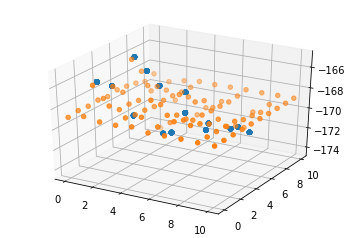

In [616]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
label = 16
ax.scatter(locations_by_mac[label][:,0], locations_by_mac[label][:,1], gps[label].predict(locations_by_mac[label])+lowest_rss)
ax.scatter(grid_locations[:,0], grid_locations[:,1], gps[label].predict(grid_locations)+lowest_rss)


In [617]:
[test_rss.shape for test_rss in test_rsss]

[(1066, 2), (1023, 2), (1004, 2)]

In [550]:
test_rsss[0].shape

(1066, 2)

In [551]:
from scipy.stats import norm

In [605]:
def fit_data(test_rsss, all_labels):
    """
    :param train_db: RSS points collected at known locations
    :param n_samples: Number of RSS samples per location
    :param n_ap: Number of access points
    :return: Wifi fingerprint database; We approximate the RSS at each location with a Gaussian
    """

    print("-> Modeling RSS with Gaussian dist...", end='')

    test_loc_scale_by_label_location = []
    
    for test_rss in test_rsss:
        rss_by_mac = [[] for i in all_labels]
        
        for label, rss in test_rss:
            rss_by_mac[label].append(rss)
            
        loc_scale_by_label = []
        for label in all_labels:
            samples = rss_by_mac[label]
            if samples:
                loc, scale = norm.fit(np.array(samples))
            else:
                loc, scale = lowest_rss, 0
            loc_scale_by_label.append((loc, scale))
            
        test_loc_scale_by_label_location.append(loc_scale_by_label)
    
    print("done")
    return test_loc_scale_by_label_location

In [618]:
test_loc_scale_by_label_location = fit_data(test_rsss, all_labels)

-> Modeling RSS with Gaussian dist...done


In [619]:
test_loc_scale_by_label_location

[[(-94, 0),
  (-94, 0),
  (-86.8, 1.4696938456699067),
  (-85.5, 1.9364916731037085),
  (-94, 0),
  (-85.0, 0.0),
  (-94, 0),
  (-94, 0),
  (-68.44117647058823, 4.145807070158448),
  (-68.41176470588235, 4.215640674627981),
  (-73.82352941176471, 2.684055187423491),
  (-73.8529411764706, 2.5796984883232845),
  (-45.14705882352941, 1.8807437974997843),
  (-45.029411764705884, 1.8548076500503012),
  (-86.5, 1.9660581414049318),
  (-87.5, 1.6278820596099706),
  (-75.61764705882354, 3.272116655139956),
  (-75.29411764705883, 2.87514103761175),
  (-85.6875, 1.7399263633843818),
  (-84.41176470588235, 2.102066868847722),
  (-84.6470588235294, 2.0705548125644753),
  (-84.84848484848484, 2.016916520278029),
  (-94, 0),
  (-94, 0),
  (-82.03225806451613, 1.8919842965955076),
  (-81.86206896551724, 1.8703519479062922),
  (-79.96153846153847, 1.807692307692308),
  (-80.76923076923077, 1.280255152084095),
  (-82.96551724137932, 1.2171974203257097),
  (-83.10344827586206, 1.028719578632848),
  (-94

In [620]:
def predict(test_loc_scale_by_label_location, train_loc_scale_by_label_grid, grid_locations):
    locations = []
    for test_loc_scale_by_label in test_loc_scale_by_label_location:
        kale_sums_by_location = []
        for train_loc_scale_by_label in train_loc_scale_by_label_grid:
            kale_sum = 0.
            for (test_loc, test_scale), (train_loc, train_scale) in zip(test_loc_scale_by_label, train_loc_scale_by_label):
                if not test_scale or not train_scale:
                    continue
                kale_sum += fingerprinting_skeleton.norm_kale(train_loc, train_scale, test_loc, test_scale)
            kale_sums_by_location.append(kale_sum)
                    
        best_location_index = np.argmin(kale_sums_by_location)
        print(best_location_index)
        best_location = grid_locations[best_location_index]
        
        locations.append(best_location)
        
    return locations
            

In [621]:
predicted_locations = predict(test_loc_scale_by_label_location, train_loc_scale_by_label_grid, grid_locations)

72
62
61


In [622]:
len(grid_locations)

100

In [623]:
import csv

In [624]:
with open('real_data/test/location.txt', 'w') as f:
    csv.writer(f).writerows(predicted_locations)